In [3]:
import sys
sys.path.append('..')

In [4]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict

In [5]:
from sklearn.metrics import mean_squared_error
from scipy import stats

### Load Data

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/fitness_prediction/GB1'

In [7]:
results_file = os.path.join(data_path, 'results_gb1.csv')
df_results = pd.read_csv(results_file)

In [8]:
df_results

,seq,fitness_raw,split_id,n_mut,fitness_log,pred_OHE_ridge,pred_OHE_RF,pred_OHE_MLP,pred_esm2_mean_ridge,pred_esm2_mean_RF,...,pred_esm2_wt_marginal,pred_esm2_masked_marginal,pred_esmc_wt_marginal,pred_esmc_masked_marginal,pred_esm2_regfit,pred_esmc_regfit,pred_esmc_confit,pred_esm2_confit,pred_esmc_pseudolikelihood,pred_esm2_pseudolikelihood
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2,0,0.000000,-0.115363,0.084982,0.083806,-2.165880,-0.365860,...,0.000000,0.000000,0.000000,0.000000,-0.130405,0.153663,0.000000,0.000000,-581.66650,-570.230626
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2,1,0.371564,-0.146706,0.301134,0.016948,-1.609487,-0.137702,...,-3.603654,-0.079431,0.250000,0.492188,-0.056291,0.077329,0.000000,0.315306,-581.12866,-568.577014
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2,1,0.524729,-0.343963,0.308464,-0.019567,-1.770170,0.133929,...,-2.920230,0.555604,0.500000,0.867188,-0.240772,-0.180687,-0.125000,0.030865,-581.75366,-568.287658
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2,1,0.157004,-0.779659,0.052084,-0.384268,-2.402546,-0.668166,...,-4.837411,-1.379841,-1.679688,-1.375000,-0.376392,-0.551990,-1.257812,-1.074926,-584.42360,-572.599549
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2,1,0.875469,0.262533,0.698862,0.249051,-0.708891,0.619847,...,-3.156260,0.137812,-0.437500,-0.312500,-0.076992,0.769737,1.312500,1.614656,-583.00366,-570.341896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8728,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYSEWTYD...,0.37,0,4,-0.994252,-1.458449,-0.787078,0.782105,-2.522320,-3.686189,...,-16.263809,-2.603973,-2.742188,-2.882812,-0.330440,-1.308552,0.207031,0.426993,-583.19824,-576.720531
8729,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,1.04,0,4,0.039221,-2.478323,-0.354582,0.248229,-0.244526,-1.020686,...,-15.044090,-2.227448,-2.742188,-2.632812,0.291335,-0.121301,-1.523438,-1.286828,-583.77880,-574.778251
8730,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,0.00,0,4,-13.815511,-6.956321,-8.802569,-6.676731,-2.267996,-6.025237,...,-15.847360,-3.210140,-3.179688,-3.757812,-13.471696,-13.648043,-7.375000,-7.209592,-590.93994,-576.899691
8731,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,0.03,0,4,-3.506558,-1.413639,-9.923905,-0.738148,-2.023953,-4.821187,...,-17.179189,-4.389381,-3.992188,-4.257812,-0.120605,-2.975160,-3.515625,-2.750988,-586.60156,-577.081927


In [9]:
df_results.columns.str.contains('pred').sum()

23

### Useful Functions

In [10]:
def get_spearmanr_bootstrap(a, b, n=1000, ci = 95):
    assert len(a) == len(b)
    corr = []
    p_values = []
    np.random.seed(0)
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        res = stats.spearmanr(a[indices], b[indices])
        
        if not np.isnan(res.statistic):
            corr.append(res.statistic)
            p_values.append(res.pvalue)

    ci_lower, ci_upper = np.percentile(corr, [100-ci, ci]) 
    mean_corr = np.mean(corr)
    p_value = np.mean(np.array(corr) < 0)

    return round(mean_corr, 2), round(ci_lower, 2), round(ci_upper, 2), round(p_value, 2), corr, p_values

In [11]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

In [12]:
name_dict = {
        'pred_OHE_ridge': 'OHE Linear',
        'pred_OHE_RF': 'OHE RF',
        'pred_OHE_MLP': 'OHE MLP',

        'pred_esm2_mean_ridge': 'ESM2 mean-embeddings Linear',
        'pred_esm2_mean_RF': 'ESM2 mean-embeddings RF',
        'pred_esm2_mean_MLP': 'ESM2 mean-embeddings MLP',
        'pred_esm2_concat_ridge': 'ESM2 concat-embeddings Linear',
        'pred_esm2_concat_RF': 'ESM2 concat-embeddings RF',

        'pred_esmc_mean_ridge': 'ESMC mean-embeddings Linear',
        'pred_esmc_mean_RF': 'ESMC mean-embeddings RF',
        'pred_esmc_mean_MLP': 'ESMC mean-embeddings MLP',
        'pred_esmc_concat_ridge': 'ESMC concat-embeddings Linear',
        'pred_esmc_concat_RF': 'ESMC concat-embeddings RF',

        'pred_esm2_wt_marginal': 'ESM2 wildtype marginal',
        'pred_esm2_masked_marginal': 'ESM2 masked marginal',
        'pred_esm2_pseudolikelihood': 'ESM2 pseudolikelihood',

        'pred_esmc_wt_marginal': 'ESMC wildtype marginal',
        'pred_esmc_masked_marginal': 'ESMC masked marginal',
        'pred_esmc_pseudolikelihood': 'ESMC pseudolikelihood',

        'pred_esm2_regfit': 'ESM2 regression finetuning',
        'pred_esmc_regfit': 'ESMC regression finetuning',

        'pred_esm2_confit': 'ESM2 contrastive finetuning',
        'pred_esmc_confit': 'ESMC contrastive finetuning',
        
    }

### All Plots

In [ ]:
def get_plot_check(df, label, fit_label='fitness_log'):
    train_mask, val_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns

    fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

    omit_mask = df['fitness_raw'] > 0

    ax[0].plot(df.loc[train_mask, fit_label], df.loc[train_mask, label], '.', alpha=0.9)
    train_corr, train_ci_lower, train_ci_upper, p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask, fit_label].to_numpy(), df.loc[train_mask, label].to_numpy())
    ax[0].set_title(f'Train\n corr {train_corr} CI ({train_ci_lower}, {train_ci_upper}) P value {p_value}')

    ax[1].plot(df.loc[train_mask, fit_label], df.loc[train_mask, label], '.', alpha=0.9)
    ax[1].plot(df.loc[train_mask & omit_mask, fit_label], df.loc[train_mask & omit_mask, label], '.', alpha=0.9)
    train_corr, train_ci_lower, train_ci_upper, p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask & omit_mask, fit_label].to_numpy(), df.loc[train_mask & omit_mask, label].to_numpy())
    ax[1].set_title(f'Train Omit\n corr {train_corr} CI ({train_ci_lower}, {train_ci_upper}) P value {p_value}')

    ax[2].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.9)
    test_corr, test_ci_lower, test_ci_upper, p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask, fit_label].to_numpy(), df.loc[test_mask, label].to_numpy())
    ax[2].set_title(f'Test\n corr {test_corr} CI ({test_ci_lower}, {test_ci_upper}) P value {p_value}')

    ax[3].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.9)
    ax[3].plot(df.loc[test_mask & omit_mask, fit_label], df.loc[test_mask & omit_mask, label], '.', alpha=0.9)
    test_corr, test_ci_lower, test_ci_upper, p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask & omit_mask, fit_label].to_numpy(), df.loc[test_mask & omit_mask, label].to_numpy())
    ax[3].set_title(f'Test\n corr {test_corr} CI ({test_ci_lower}, {test_ci_upper}) P value {p_value}')
    
    for i in range(4):
        ax[i].set_xlabel('True')
        ax[i].set_ylabel('Pred')

    plt.show()

In [ ]:
for label in df_results.columns[df_results.columns.str.contains('pred')]:
    print(label)
    get_plot_check(df_results, label, fit_label='fitness_log')

### Tables

In [ ]:
def get_table(df, fit_label='fitness_log', omit=True, omit_label=None):
    table = {}
    train_mask, val_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns
    for label in df.columns[df.columns.str.contains('pred')]:
        if omit:
            assert omit_label is not None and omit_label in df.columns
            omit_mask = df[omit_label] > 0
            train_corr, train_ci_lower, train_ci_upper, train_p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask & omit_mask, fit_label].to_numpy(), df.loc[train_mask & omit_mask, label].to_numpy())
            test_corr, test_ci_lower, test_ci_upper, test_p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask & omit_mask, fit_label].to_numpy(), df.loc[test_mask & omit_mask, label].to_numpy())
        else:
            train_corr, train_ci_lower, train_ci_upper, train_p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask, fit_label].to_numpy(), df.loc[train_mask, label].to_numpy())
            test_corr, test_ci_lower, test_ci_upper, test_p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask, fit_label].to_numpy(), df.loc[test_mask, label].to_numpy())
        
        table[label] = [train_corr, (train_ci_lower, train_ci_upper), train_p_value, test_corr, (test_ci_lower, test_ci_upper), test_p_value]

    df_table = pd.DataFrame(table).T
    df_table.columns = ['train', 'train CI', 'train p-val', 'test', 'test CI', 'test p-val']

    return df_table

In [ ]:
res_table = get_table(df_results, omit=True, fit_label='fitness_log', omit_label='fitness_raw')

In [ ]:
res_table

In [ ]:
res_table.sort_values(by='test', ascending=False).index

In [ ]:
res_table[res_table['test p-val'] < 0.05]

In [ ]:
temp_table = {}
for i, row in res_table.iterrows():
    temp_table[row.name] = [f"{row['test']} {row['test CI']}"]
temp_table = pd.DataFrame(temp_table).T

In [ ]:
temp_table

### Panel

In [ ]:
def get_panel(df, label, fit_label='fitness_log', omit=True, omit_label=None):
    train_mask, val_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns

    fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

    if omit:
        assert omit_label is not None and omit_label in df.columns
        
        omit_mask = df[omit_label] > 0

        ax[0].plot(df.loc[train_mask & omit_mask, fit_label], df.loc[train_mask & omit_mask, label], '.', alpha=0.9)
        ax[1].plot(df.loc[test_mask & omit_mask,fit_label], df.loc[test_mask & omit_mask, label], '.', alpha=0.9)

        train_corr, train_ci_lower, train_ci_upper, *_  = get_spearmanr_bootstrap(df.loc[train_mask & omit_mask, fit_label].to_numpy(), df.loc[train_mask & omit_mask, label].to_numpy())
        test_corr, test_ci_lower, test_ci_upper, *_ = get_spearmanr_bootstrap(df.loc[test_mask & omit_mask, fit_label].to_numpy(), df.loc[test_mask & omit_mask, label].to_numpy())

        ax[0].set_title(f'Train\nspearman corr {train_corr} CI ({train_ci_lower}, {train_ci_upper})')
        ax[1].set_title(f'Test\nspearman corr {test_corr} CI ({test_ci_lower}, {test_ci_upper})')
    else:
        ax[0].plot(df.loc[train_mask, fit_label], df.loc[train_mask, label], '.', alpha=0.9)
        ax[1].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.9)

        train_corr, train_ci_lower, train_ci_upper, *_  = get_spearmanr_bootstrap(df.loc[train_mask, fit_label].to_numpy(), df.loc[train_mask, label].to_numpy())
        test_corr, test_ci_lower, test_ci_upper, *_ = get_spearmanr_bootstrap(df.loc[test_mask, fit_label].to_numpy(), df.loc[test_mask, label].to_numpy())

        ax[0].set_title(f'Train\nspearman corr {train_corr} CI ({train_ci_lower}, {train_ci_upper})')
        ax[1].set_title(f'Test\nspearman corr {test_corr} CI ({test_ci_lower}, {test_ci_upper})')
    
    for i in range(2):
        ax[i].set_xlabel('True')
        ax[i].set_ylabel('Pred')

    plt.show()

In [ ]:
get_panel(df_results, 'pred_esm2_wt_marginal', omit=True, fit_label='fitness_log', omit_label='fitness_raw')

### Comparison

In [13]:
def get_diff(y, a, b, n=1000, ci = 95):

    assert len(y) == len(a) == len(b)
    
    corr_a_list = []
    corr_b_list = []
    diff_corr = []
    np.random.seed(0)
    
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        corr_a = stats.spearmanr(y[indices], a[indices]).statistic
        corr_b = stats.spearmanr(y[indices], b[indices]).statistic
        
        assert not np.isnan(corr_a)
        assert not np.isnan(corr_b)

        corr_a_list.append(corr_a)
        corr_b_list.append(corr_b)

        diff_corr.append(corr_a - corr_b)

    ci_lower, ci_upper = np.percentile(diff_corr, [5, 95]) 
    p_value = np.mean(np.array(diff_corr) < 0)

    # plt.hist(corr_b_list)
    # plt.hist(corr_a_list)
    
    return p_value, ci_lower, ci_upper

In [14]:
train_mask, val_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0

get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), df_results.loc[test_mask & omit_mask, 'pred_esmc_concat_ridge'].to_numpy(), df_results.loc[test_mask & omit_mask, 'pred_esmc_confit'].to_numpy())

(1.0, -0.03751545924535421, -0.016017005075896214)

In [ ]:
order_list = ['pred_esmc_regfit', 'pred_OHE_RF', 'pred_esmc_confit',
       'pred_esmc_concat_ridge', 'pred_esm2_confit', 'pred_esm2_concat_ridge',
       'pred_esm2_concat_RF', 'pred_esm2_regfit', 'pred_esmc_concat_RF',
       'pred_OHE_ridge', 'pred_OHE_MLP', 'pred_esm2_mean_MLP',
       'pred_esm2_mean_RF', 'pred_esmc_mean_RF', 'pred_esm2_mean_ridge',
       'pred_esmc_mean_MLP', 'pred_esmc_pseudolikelihood',
       'pred_esmc_mean_ridge', 'pred_esmc_wt_marginal',
       'pred_esmc_masked_marginal', 'pred_esm2_pseudolikelihood',
       'pred_esm2_wt_marginal', 'pred_esm2_masked_marginal']

for i in range(len(order_list)):
    print(f'{order_list[i]}:-')
    for j in range(i+1, len(order_list)):

        p, *_ = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, order_list[i]].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, order_list[j]].to_numpy())
        
        if p >= 0.05:
            print(order_list[i], order_list[j], p)

    print(' ')

In [15]:
order_list = ['pred_esmc_regfit', 'pred_OHE_RF', 'pred_esmc_confit', 'pred_esmc_concat_ridge', 'pred_esm2_confit']
significance_matrix = np.zeros((len(order_list), len(order_list)))
for i in range(len(order_list)):
    for j in range(len(order_list)):

        p, *_ = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_raw'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, order_list[i]].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, order_list[j]].to_numpy())
        
        significance_matrix[i,j] = p

In [16]:
significance_matrix

array([[0.   , 0.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.03 , 0.   , 0.   ],
       [1.   , 0.97 , 0.   , 0.   , 0.   ],
       [1.   , 1.   , 1.   , 0.   , 0.609],
       [1.   , 1.   , 1.   , 0.391, 0.   ]])

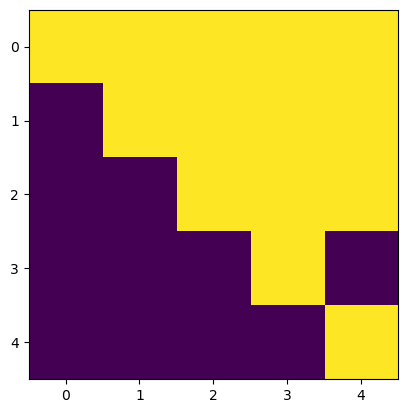

In [17]:
plt.imshow(significance_matrix < 0.05)

### ESMC vs ESM2

In [12]:
def get_diff(y, a, b, n=1000, ci = 95):

    assert len(y) == len(a) == len(b)
    
    corr_a_list = []
    corr_b_list = []
    diff_corr = []
    np.random.seed(0)
    
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        corr_a = stats.spearmanr(y[indices], a[indices]).statistic
        corr_b = stats.spearmanr(y[indices], b[indices]).statistic
        
        assert not np.isnan(corr_a)
        assert not np.isnan(corr_b)

        corr_a_list.append(corr_a)
        corr_b_list.append(corr_b)

        diff_corr.append(corr_a - corr_b)

    ci_lower, ci_upper = np.percentile(diff_corr, [5, 95]) 
    p_value = np.mean(np.array(diff_corr) < 0)

    # plt.hist(corr_b_list)
    # plt.hist(corr_a_list)
    
    return p_value, corr_a_list, corr_b_list

In [13]:
esmc_indicater = ['pred_esmc_mean_ridge', 'pred_esmc_mean_RF', 'pred_esmc_mean_MLP', 'pred_esmc_concat_ridge', 'pred_esmc_concat_RF',
                  'pred_esmc_wt_marginal', 'pred_esmc_masked_marginal', 'pred_esmc_pseudolikelihood', 'pred_esmc_regfit', 
                  'pred_esmc_confit']
esm2_indicater = ['pred_esm2_mean_ridge', 'pred_esm2_mean_RF', 'pred_esm2_mean_MLP', 'pred_esm2_concat_ridge', 'pred_esm2_concat_RF',
                  'pred_esm2_wt_marginal', 'pred_esm2_masked_marginal', 'pred_esm2_pseudolikelihood', 'pred_esm2_regfit', 
                  'pred_esm2_confit']

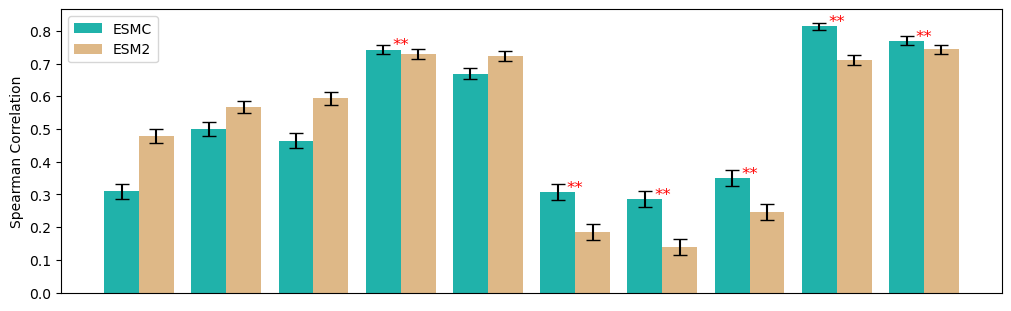

In [21]:
train_mask, val_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0

fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
ax.set_xticks([])
# ax.set_xticks(range(len(esmc_indicater)))
# ax.set_xticklabels([f"{name_dict.get(x, x).replace('ESMC ', '')}" for x in esmc_indicater], rotation=45, ha='right')

for a, b in zip(esmc_indicater, esm2_indicater):
    p, dist_a, dist_b = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())
    
    # Calculate mean and confidence intervals
    mean_a, mean_b = np.mean(dist_a), np.mean(dist_b)
    ci_a = np.percentile(dist_a, [5, 95])
    ci_b = np.percentile(dist_b, [5, 95])

    x_pos = len(ax.patches) // 2
    if len(ax.patches) == 0:
        ax.bar(x_pos - 0.2, mean_a, yerr=[[mean_a - ci_a[0]], [ci_a[1] - mean_a]], capsize=5, color='lightseagreen', width=0.4, label='ESMC')
        ax.bar(x_pos + 0.2, mean_b, yerr=[[mean_b - ci_b[0]], [ci_b[1] - mean_b]], capsize=5, color='burlywood', width=0.4, label='ESM2')
    else:
        ax.bar(x_pos - 0.2, mean_a, yerr=[[mean_a - ci_a[0]], [ci_a[1] - mean_a]], capsize=5, color='lightseagreen', width=0.4)
        ax.bar(x_pos + 0.2, mean_b, yerr=[[mean_b - ci_b[0]], [ci_b[1] - mean_b]], capsize=5, color='burlywood', width=0.4)

    # Add significance marker
    if p < 0.05:
        ax.text(x_pos, max(mean_a, mean_b) - 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')

ax.set_ylabel('Spearman Correlation')
ax.legend()
plt.show()    


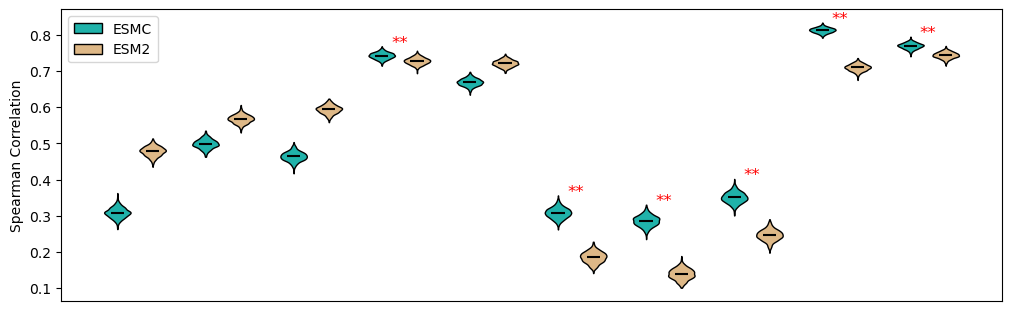

In [20]:
train_mask, val_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0

fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
ax.set_xticks([])
# ax.set_xticks(range(len(esmc_indicater)))
# ax.set_xticklabels([f"{name_dict.get(x, x).replace('ESMC ', '')}" for x in esmc_indicater], rotation=45, ha='right')
positions = np.arange(len(esmc_indicater))  # Set positions for the bars

for _i, (a, b) in enumerate(zip(esmc_indicater, esm2_indicater)):
    p, dist_a, dist_b = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())
    
    x_pos = positions[_i]
    bp = ax.violinplot(dist_a, positions=[x_pos - 0.2], widths=0.3, showmeans=True, showextrema=False)
    bp['cmeans'].set_color('black')
    for pc in bp['bodies']:
        pc.set_facecolor('lightseagreen')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    bp = ax.violinplot(dist_b, positions=[x_pos + 0.2], widths=0.3, showmeans=True, showextrema=False)
    bp['cmeans'].set_color('black')
    for pc in bp['bodies']:
        pc.set_facecolor('burlywood')
        pc.set_alpha(1)
        pc.set_edgecolor('black')

    # Add significance marker
    if p < 0.05:
        ax.text(x_pos, max(max(dist_a), max(dist_b)) - 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')

ax.set_ylabel('Spearman Correlation')
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='lightseagreen', edgecolor='black', label='ESMC'),
    Patch(facecolor='burlywood', edgecolor='black', label='ESM2')
]
ax.legend(handles=legend_handles, loc='upper left')
plt.show()    


### Concat vs mean

In [14]:
def get_diff(y, a, b, n=1000, ci = 95):

    assert len(y) == len(a) == len(b)
    
    corr_a_list = []
    corr_b_list = []
    diff_corr = []
    np.random.seed(0)
    
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        corr_a = stats.spearmanr(y[indices], a[indices]).statistic
        corr_b = stats.spearmanr(y[indices], b[indices]).statistic
        
        assert not np.isnan(corr_a)
        assert not np.isnan(corr_b)

        corr_a_list.append(corr_a)
        corr_b_list.append(corr_b)

        diff_corr.append(corr_a - corr_b)

    ci_lower, ci_upper = np.percentile(diff_corr, [5, 95]) 
    p_value = np.mean(np.array(diff_corr) < 0)

    # plt.hist(corr_b_list)
    # plt.hist(corr_a_list)
    
    return p_value, ci_lower, ci_upper

In [15]:
train_mask, val_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0

In [16]:
concat_list = ['pred_esmc_concat_ridge', 'pred_esmc_concat_RF']
mean_list = ['pred_esmc_mean_ridge', 'pred_esmc_mean_RF', 'pred_esmc_mean_MLP']
significance_matrix = np.zeros((len(concat_list), len(mean_list)))
for a in concat_list:
    for b in mean_list:

        p, *_ = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_raw'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())

        significance_matrix[concat_list.index(a), mean_list.index(b)] = p

significance_matrix

array([[0., 0., 0.],
       [0., 0., 0.]])

In [18]:
concat_list = ['pred_esm2_concat_ridge', 'pred_esm2_concat_RF']
mean_list = ['pred_esm2_mean_ridge', 'pred_esm2_mean_RF', 'pred_esm2_mean_MLP']
significance_matrix = np.zeros((len(concat_list), len(mean_list)))
for a in concat_list:
    for b in mean_list:

        p, *_ = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_raw'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())

        significance_matrix[concat_list.index(a), mean_list.index(b)] = p

significance_matrix

array([[0., 0., 0.],
       [0., 0., 0.]])